In [1]:
# %load plot_template.py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

plt.rc('font', family='serif')
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10, color='grey')
plt.rc('ytick', labelsize=10, color='grey')
plt.rc('legend', fontsize=12, loc='lower left')
plt.rc('figure', titlesize=12)
plt.rc('savefig', dpi=330, bbox='tight')
%matplotlib inline

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

from piecewise import InverseModel
import lightgbm as lgb

In [8]:
# Replace PATH_TO_ROOT

import sys
PATH_TO_ROOT = '/Users/guanyuxiaoxiong/City-Scale-Electricity-Use-Prediction-master'
sys.path.insert(0,PATH_TO_ROOT)

In [9]:
def generate_fig_path(fig_name):
    '''
    Generate the figure path and name
    To be used by plt.savefig function
    '''
    return '{}/results/fig/section4.2 heat wave/{}'.format(PATH_TO_ROOT, fig_name)

def generate_input_data_path(data_name):
    '''
    Generate the path to input data
    '''
    return '{}/results/data/{}.csv'.format(PATH_TO_ROOT, data_name)

def generate_result_data_path(data_name):
    '''
    Generate the path to save the result data
    '''
    return '{}/results/data/{}.csv'.format(PATH_TO_ROOT, data_name)

In [10]:
def piecewise_linear(x, base, hcp, hsl, ccp, csl):
    #  k1  \              / k2
    #       \            /
    # y0     \__________/
    #        cpL      cpR

    # Handle 3P models when use this function to predict.
    if np.isnan(hcp) and np.isnan(hsl):
        hcp = ccp
        hsl = 0
    if np.isnan(csl) and np.isnan(csl):
        ccp = hcp
        csl = 0

    conds = [x < hcp, (x >= hcp) & (x <= ccp), x > ccp]

    funcs = [lambda x: hsl * x + base - hsl * hcp,
             lambda x: base,
             lambda x: csl * x + base - csl * ccp]

    return np.piecewise(x, conds, funcs)

In [11]:
# set up the hyper-parameter for lightGBM
params = {}
params['learning_rate'] = 0.005
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mse'
# params['sub_feature'] = 0.5
params['num_leaves'] = 4
params['min_data_in_leaf'] = 30
params['max_depth'] = 5

In [12]:
title = {'la': 'Los Angeles', 'sac':'Sacramento', 'ny':'New York'}
regions = ['la','sac','ny']

temp_plot = np.arange(20, 45, 0.5)

data_all = {}
predict_sum_all = {}
predict_peak_all = {}

for index in range(3):

    region = regions[index]
    data = pd.read_csv(generate_input_data_path(f'{region}_daily'), index_col=0)

    # train 5p model
    data_wd = data[data['Day Type']=='Working Day']
    model_sum = InverseModel(data_wd['Temperature, daily mean (degC)'].values, 
                             data_wd['Electricity demand, daily sum, (GWh)'].values, 'Electricity demand, daily sum, (GWh)')
    model_sum.fit_model()
    predict_sum_5p = piecewise_linear(temp_plot, *model_sum.model_p)

    model_peak = InverseModel(data_wd['Temperature, daily mean (degC)'].values, 
                              data_wd['Electricity power, daily peak, (GW)'].values, 'Electricity power, daily peak, (GW)')
    model_peak.fit_model()
    predict_peak_5p = piecewise_linear(temp_plot, *model_peak.model_p)
    # train lightGBM model
    data.index = pd.to_datetime(data.index)
    data['Month'] = data.index.month
    data['dayOfWeek'] = data.index.weekday
    data = data.dropna()
    X_train = data[['Temperature, daily mean (degC)', 'Non-workDay', 'Month']].values
    y_sum_train = data['Electricity demand, daily sum, (GWh)'].values
    y_peak_train = data['Electricity power, daily peak, (GW)'].values
    d_sum_train = lgb.Dataset(X_train, categorical_feature=[1,2], label=y_sum_train)
    d_peak_train = lgb.Dataset(X_train, categorical_feature=[1,2], label=y_peak_train)
    clf_sum = lgb.train(params, d_sum_train, 5000)
    clf_peak = lgb.train(params, d_peak_train, 5000)
    X_test_temp = pd.DataFrame({'Temperature, daily mean (degC)':temp_plot})
    X_test_temp['Non-workDay'] = False
    X_test_temp['Month'] = 8
    predict_sum_lgmb = clf_sum.predict(X_test_temp.values)
    predict_peak_lgmb = clf_peak.predict(X_test_temp.values)

    predict_sum = pd.DataFrame({'5-parameter': predict_sum_5p, 'lightGBM': predict_sum_lgmb}, index=temp_plot)
    predict_peak = pd.DataFrame({'5-parameter': predict_peak_5p, 'lightGBM': predict_peak_lgmb}, index=temp_plot)
    
    data_all[region] = data_wd
    predict_sum_all[region] = predict_sum
    predict_peak_all[region] = predict_peak

/Users/guanyuxiaoxiong/opt/anaconda3/envs/cityEleEnv/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 1911, number of used features: 3
[LightGBM] [Info] Start training from score 77.127232
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 1911, number of used features: 3
[LightGBM] [Info] Start training from score 3.941828


/Users/guanyuxiaoxiong/opt/anaconda3/envs/cityEleEnv/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 1913, number of used features: 3
[LightGBM] [Info] Start training from score 48.193331
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 1913, number of used features: 3
[LightGBM] [Info] Start training from score 2.556058


/Users/guanyuxiaoxiong/opt/anaconda3/envs/cityEleEnv/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 1913, number of used features: 3
[LightGBM] [Info] Start training from score 433.187614
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 1913, number of used features: 3
[LightGBM] [Info] Start training from score 20.865410


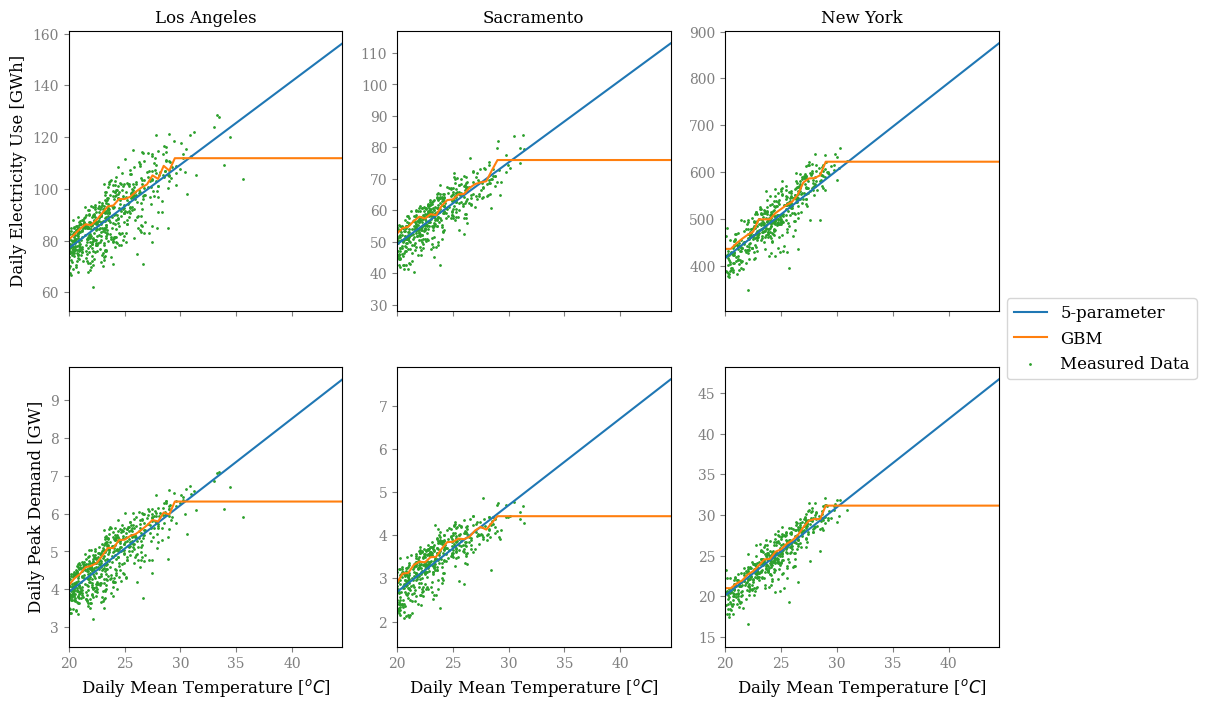

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True)

for index in range(3):
    region = regions[index]
    data = data_all[region]
    predict_sum = predict_sum_all[region] 
    predict_peak = predict_peak_all[region]
    
    axes[0, index].set_title(title[region])
    axes[0, index].plot(temp_plot, predict_sum['5-parameter'].values, label='5-parameter', color=default_colors[0])
    axes[0, index].plot(temp_plot, predict_sum['lightGBM'].values, label='GBM', color=default_colors[1]) 
    axes[0, index].scatter(data['Temperature, daily mean (degC)'].values,
                           data['Electricity demand, daily sum, (GWh)'].values, label='Measured Data',
                           s=1, color=default_colors[2])
    
    axes[0, index].set_xlim(temp_plot[0], temp_plot[-1])
    
    axes[1, index].plot(temp_plot, predict_peak['5-parameter'].values, label='5-parameter', color=default_colors[0])
    axes[1, index].plot(temp_plot, predict_peak['lightGBM'].values, label='GBM', color=default_colors[1]) 
    axes[1, index].scatter(data['Temperature, daily mean (degC)'].values,
                           data['Electricity power, daily peak, (GW)'].values, label='Measured Data',
                           s=1, color=default_colors[2])
    axes[1, index].set_xlabel('Daily Mean Temperature [$^oC$]') 
    axes[1, index].set_xlim(temp_plot[0], temp_plot[-1])
axes[0, 0].set_ylabel('Daily Electricity Use [GWh]')
axes[1, 0].set_ylabel('Daily Peak Demand [GW]')
axes[1, 2].legend(loc='center left', bbox_to_anchor=(1, 1.1))

plt.savefig(generate_fig_path('Figure 17'))